# Initial Setup and Data Loading

Initially all required libraries for data analysis and visualization are imported. This includes pandas for data manipulation, matplotlib and seaborn for visualization, and various other utilities needed for data processing.

# Mount Google Drive and Set File Paths

Then, Google Drive is mounted and paths for both Instagram and Letterboxd data files are defined to access the datafiles.

In [20]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import requests
from bs4 import BeautifulSoup
import time
import random
import re
from urllib.parse import urlparse
import calendar
from scipy import stats

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
base_directory = "/content/drive/MyDrive/meta-2024-Nov-25-11-52-50"
instagram_file_path = f'{base_directory}/instagram-gercekten.idil-2024-11-25-xmCJFTlJ/your_instagram_activity/likes/liked_posts.json'
letterboxd_file_path = f'{base_directory}/letterboxd-idilmuftuoglu-2024-12-11-15-57-utc/diary.csv'

liked_posts.json has the following structure and only the timestamp data is needed. Therefore, the nested structure is flatten to title and timestamp in the following part:

 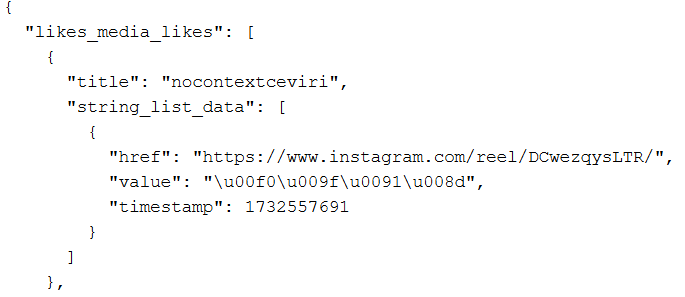

 # Process Instagram Data

Load and process the Instagram likes data from the JSON file. The data structure is nested, so we:
1. Read the JSON file
2. Flatten the nested structure to extract only title and timestamp
3. Convert Unix timestamps to readable datetime format
4. Display the first few rows to verify the data

Instagram data is used to represent short-time content for entertainment.

In [22]:
with open(instagram_file_path, 'r') as file:
    data = json.load(file)

# Use json_normalize to flatten the nested structure
# Specify the paths to extract the data needed
df_instagram = pd.json_normalize(
    data['likes_media_likes'],
    record_path='string_list_data',
    meta=['title'],
    errors='ignore'
)[['title', 'timestamp']]

df_instagram['timestamp'] = pd.to_datetime(df_instagram['timestamp'], unit='s')

# Display the first few rows
print(df_instagram.head())

               title           timestamp
0    nocontextceviri 2024-11-25 18:01:31
1     gatitos_ultras 2024-11-25 17:26:40
2             admbrs 2024-11-25 17:25:50
3         gibiyoloji 2024-11-25 17:25:31
4  askokuskoyuzbeybi 2024-11-25 17:04:59


# Define Life Periods

Create a function to categorize timestamps into distinct periods of life:
- 1.University (Dec 2018 - Jun 2020)
- Full-time Work (Oct 2020 - Sep 2022)
- Exam Preparation (Oct 2022 - Jun 2023)
- 2.University (Oct 2023 - Nov 2024)

Apply this categorization to the Instagram data and remove any undefined periods.

In [23]:
def assign_custom_period(timestamp):
    if pd.Timestamp('2018-12-16') <= timestamp < pd.Timestamp('2020-06-20'):
        return '1. University'
    elif pd.Timestamp('2020-10-05') <= timestamp < pd.Timestamp('2022-09-30'):
        return 'Full-time Work'
    elif pd.Timestamp('2022-10-01') <= timestamp < pd.Timestamp('2023-06-18'):
        return 'Exam Preperation'
    elif pd.Timestamp('2023-10-02') <= timestamp <= pd.Timestamp('2024-11-26'):
        return '2. University'
    else:
        return 'Undefined Period'

df_instagram['custom_period'] = df_instagram['timestamp'].apply(assign_custom_period)
df_instagram = df_instagram[df_instagram['custom_period'] != 'Undefined Period']
df_instagram

,title,timestamp,custom_period
0,nocontextceviri,2024-11-25 18:01:31,2. University
1,gatitos_ultras,2024-11-25 17:26:40,2. University
2,admbrs,2024-11-25 17:25:50,2. University
3,gibiyoloji,2024-11-25 17:25:31,2. University
4,askokuskoyuzbeybi,2024-11-25 17:04:59,2. University
...,...,...,...
33049,niluferbs,2018-12-17 08:54:09,1. University
33050,brooklyn99,2018-12-17 08:53:06,1. University
33051,comics,2018-12-16 23:04:14,1. University
33052,marvelograf,2018-12-16 19:33:47,1. University


# Analyze Daily Instagram Activity

A comprehensive analysis function is created that:
1. Processes daily Instagram likes
2. Creates a complete timeline for each life period
3. Fills in missing days with zero counts
4. Calculates summary statistics for each period including:
   - Mean, median, min, and max likes per day
   - Total number of likes
   - Standard deviation
   - Date range and total days in period

In [24]:
def analyze_daily_likes(df, date_column='timestamp', group_column='custom_period'):
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df[date_column]).dt.date

    # Get initial daily counts
    daily_counts = df_copy.groupby([group_column, 'date']).size().reset_index(name='count')

    # Initialize list to store complete data for each period
    complete_data = []

    # Process each period separately
    for period in daily_counts[group_column].unique():
        # Filter data for current period
        period_data = daily_counts[daily_counts[group_column] == period]

        date_range = pd.date_range(
            start=pd.to_datetime(period_data['date'].min()),
            end=pd.to_datetime(period_data['date'].max()),
            freq='D'
        ).date

        template = pd.DataFrame({
            'date': date_range,
            group_column: period
        })

        merged = pd.merge(
            template,
            period_data,
            on=['date', group_column],
            how='left'
        )

        # Fill missing values with 0
        merged['count'] = merged['count'].fillna(0)
        complete_data.append(merged)

    # Combine all periods
    complete_daily_counts = pd.concat(complete_data, ignore_index=True)

    complete_daily_counts = complete_daily_counts.sort_values([group_column, 'date'])

    # Calculate summary statistics
    summary_stats = complete_daily_counts.groupby(group_column).agg({
        'count': ['mean', 'median', 'min', 'max', 'sum', 'std'],
        'date': ['min', 'max', 'count']
    }).round(2)

    return complete_daily_counts, summary_stats

complete_counts_instagram, summary_instagram = analyze_daily_likes(df_instagram)

print("Sample of complete daily counts (including zero-activity days):")
print(complete_counts_instagram.head(10))

print("\nSummary statistics by period:")
print(summary_instagram)

Sample of complete daily counts (including zero-activity days):
         date  custom_period  count
0  2018-12-16  1. University    3.0
1  2018-12-17  1. University   12.0
2  2018-12-18  1. University    4.0
3  2018-12-19  1. University    9.0
4  2018-12-20  1. University    7.0
5  2018-12-21  1. University   11.0
6  2018-12-22  1. University   13.0
7  2018-12-23  1. University    3.0
8  2018-12-24  1. University    5.0
9  2018-12-25  1. University    6.0

Summary statistics by period:
                  count                                           date  \
                   mean median  min    max      sum    std         min   
custom_period                                                            
1. University     10.30    9.0  0.0   94.0   5686.0  10.82  2018-12-16   
2. University     17.52   14.0  0.0   92.0   7374.0  15.19  2023-10-02   
Exam Preperation  12.28    9.0  0.0   94.0   3192.0  11.91  2022-10-01   
Full-time Work    17.67   14.0  0.0  101.0  12811.0  17.12  2020-

# Visualize Daily Instagram Activity

Scatter plots of daily Instagram activity for each life period are created with:
1. Standardized y-axis scale for easy comparison between periods
2. Mean activity line shown as a dashed red line

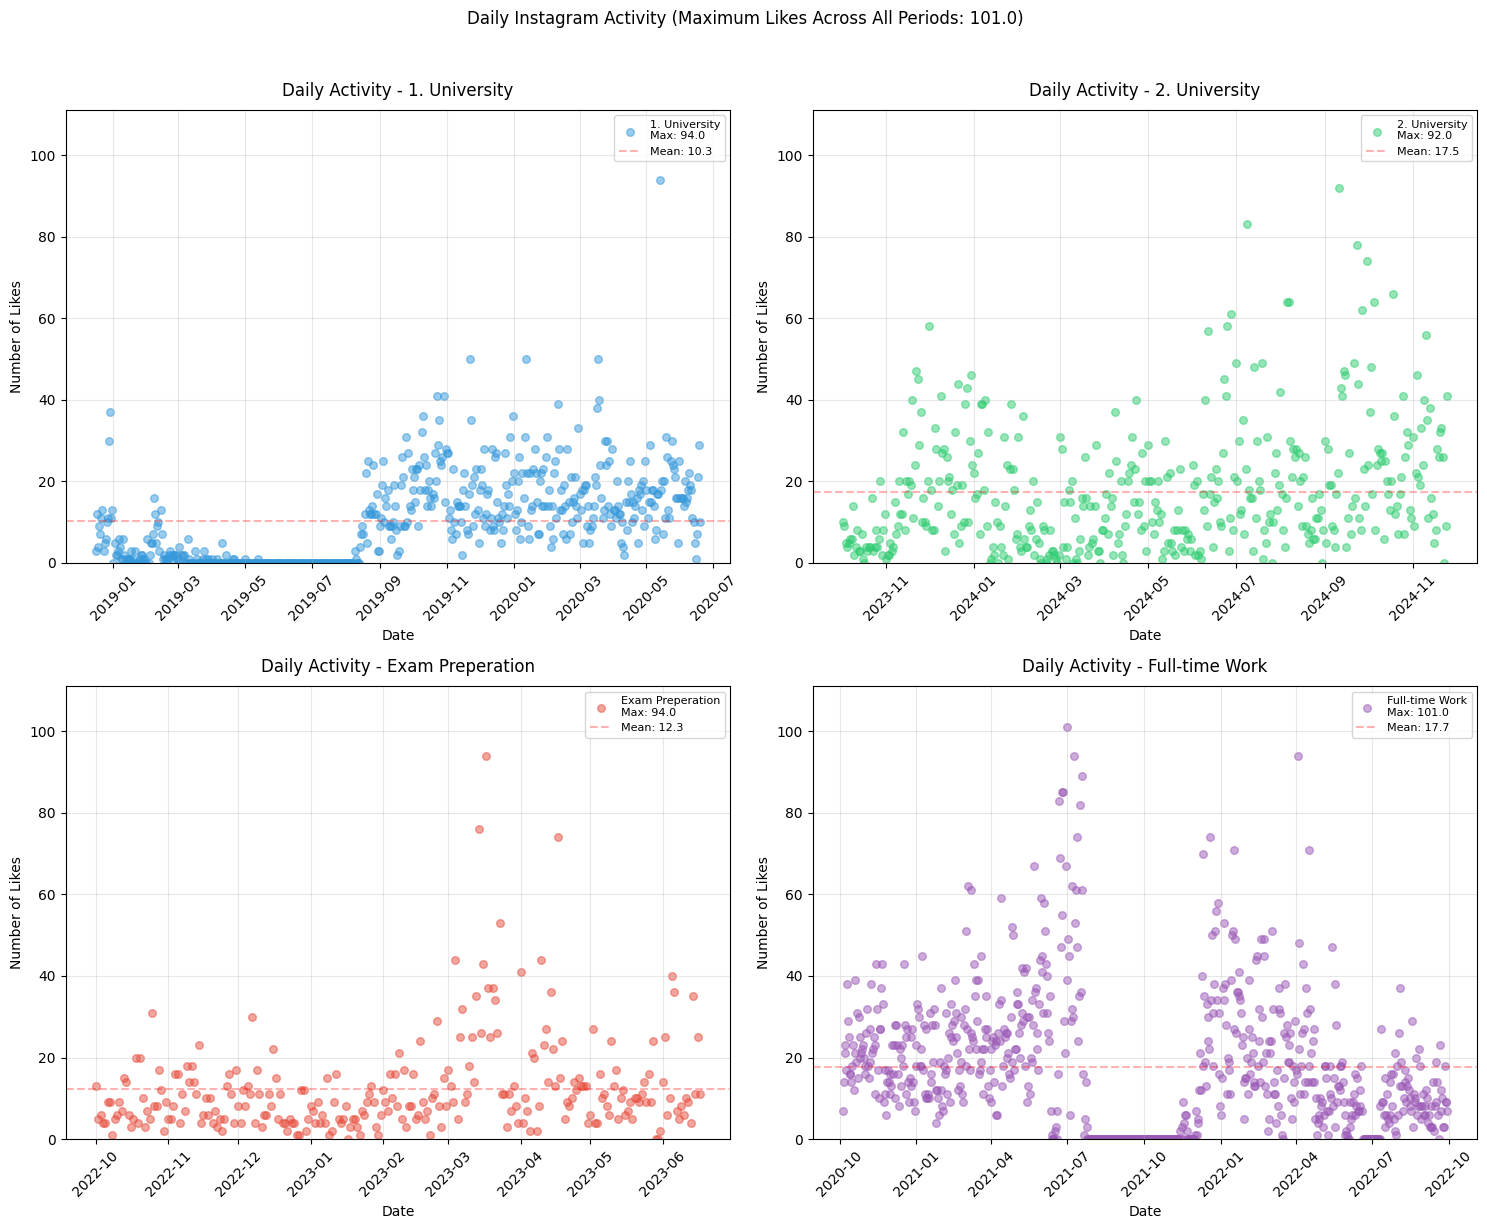


Maximum likes by period:
1. University: 94.0 likes
2. University: 92.0 likes
Exam Preperation: 94.0 likes
Full-time Work: 101.0 likes


In [25]:
def create_activity_plots_standardized(complete_counts):
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    max_count = complete_counts['count'].max()

    y_max = max_count * 1.1

    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

    for idx, (period, group) in enumerate(complete_counts.groupby('custom_period')):
        ax = axes[idx]

        ax.scatter(
            group['date'],
            group['count'],
            alpha=0.5,
            s=30,
            c=colors[idx],
            label=f'{period}\nMax: {group["count"].max()}'
        )

        ax.set_ylim(0, y_max)

        ax.set_title(f'Daily Activity - {period}', pad=10)
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Likes')

        ax.tick_params(axis='x', rotation=45)

        ax.grid(True, alpha=0.3)

        mean_likes = group['count'].mean()
        ax.axhline(y=mean_likes, color='red', linestyle='--', alpha=0.3,
                  label=f'Mean: {mean_likes:.1f}')

        ax.legend(fontsize=8, loc='upper right')

    fig.suptitle(f'Daily Instagram Activity (Maximum Likes Across All Periods: {max_count})',
                y=1.02, fontsize=12)

    plt.tight_layout()

    return fig

# Create the visualization
fig = create_activity_plots_standardized(complete_counts_instagram)
plt.show()

print("\nMaximum likes by period:")
for period, group in complete_counts_instagram.groupby('custom_period'):
    print(f"{period}: {group['count'].max()} likes")

# Visualize Cleaned Instagram Activity Data

I realized that there are some outlier sequences where I deliberately did not use Instagram. These periods are not normal and should be removed.

That is why I created scatter plots using the cleaned data that excludes outlier sequences (greater than or equal to 7 days of inactivity). This provides a clearer view of typical Instagram usage patterns.

In [26]:
def clean_outlier_sequences(df, window_size=7):
    cleaned_df = df.copy()

    for period in cleaned_df['custom_period'].unique():
        period_mask = cleaned_df['custom_period'] == period
        period_data = cleaned_df[period_mask].copy()

        zero_mask = period_data['count'] == 0
        rolling_zeros = zero_mask.rolling(window=window_size, min_periods=1).sum()

        dates_to_remove = period_data[rolling_zeros >= window_size].index

        if len(dates_to_remove) > 0:
            print(f"\nRemoving outlier sequence from {period}:")
            print(f"Removed {len(dates_to_remove)} days")
            print(f"Date range: {period_data.loc[dates_to_remove, 'date'].min()} to {period_data.loc[dates_to_remove, 'date'].max()}")

        cleaned_df = cleaned_df.drop(dates_to_remove)

    return cleaned_df

cleaned_counts_instagram = clean_outlier_sequences(complete_counts_instagram)

print("\nBefore cleaning:")
print(complete_counts_instagram.groupby('custom_period')['count'].agg(['count', 'mean', 'min', 'max']))

print("\nAfter cleaning:")
print(cleaned_counts_instagram.groupby('custom_period')['count'].agg(['count', 'mean', 'min', 'max']))


Removing outlier sequence from 1. University:
Removed 89 days
Date range: 2019-04-28 to 2019-08-08

Removing outlier sequence from Full-time Work:
Removed 123 days
Date range: 2021-07-31 to 2022-07-10

Before cleaning:
                  count       mean  min    max
custom_period                                 
1. University       552  10.300725  0.0   94.0
2. University       421  17.515439  0.0   92.0
Exam Preperation    260  12.276923  0.0   94.0
Full-time Work      725  17.670345  0.0  101.0

After cleaning:
                  count       mean  min    max
custom_period                                 
1. University       463  12.280778  0.0   94.0
2. University       421  17.515439  0.0   92.0
Exam Preperation    260  12.276923  0.0   94.0
Full-time Work      602  21.280731  0.0  101.0


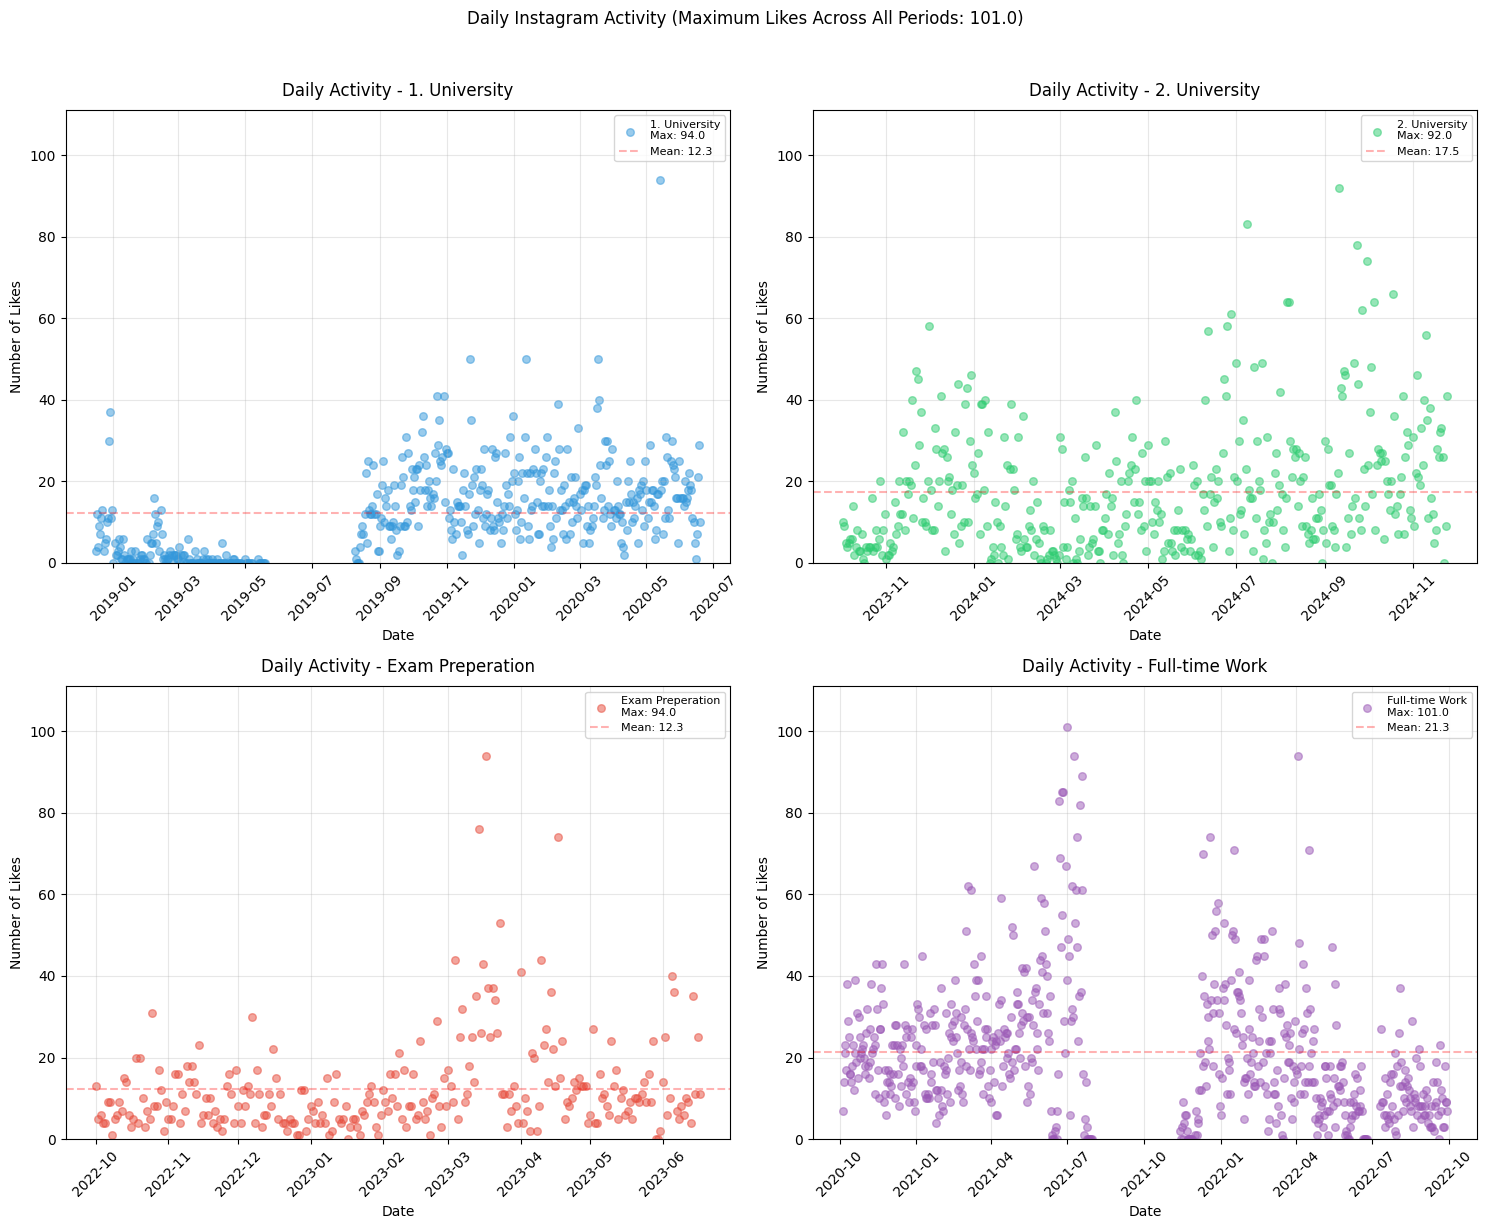


Maximum likes by period:
1. University: 94.0 likes
2. University: 92.0 likes
Exam Preperation: 94.0 likes
Full-time Work: 101.0 likes


In [27]:
fig = create_activity_plots_standardized(cleaned_counts_instagram)
plt.show()

print("\nMaximum likes by period:")
for period, group in cleaned_counts_instagram.groupby('custom_period'):
    print(f"{period}: {group['count'].max()} likes")


Detailed Statistics by Period:
                  count       mean        std  min  25%   50%    75%    max
custom_period                                                              
1. University     463.0  12.280778  10.736866  0.0  3.0  11.0  18.00   94.0
2. University     421.0  17.515439  15.191723  0.0  6.0  14.0  24.00   92.0
Exam Preperation  260.0  12.276923  11.906661  0.0  5.0   9.0  15.00   94.0
Full-time Work    602.0  21.280731  16.613626  0.0  9.0  18.0  28.75  101.0


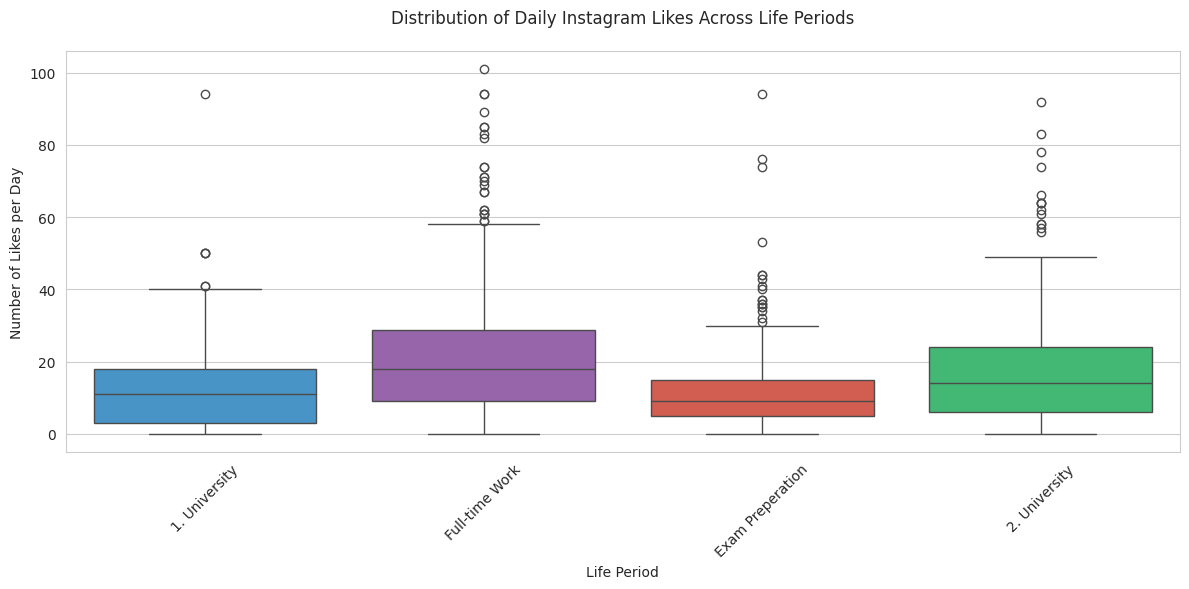

In [28]:
# Create side-by-side boxplots for all periods for comparison
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

box_plot = sns.boxplot(
    data=cleaned_counts_instagram,
    x='custom_period',
    y='count',
    hue='custom_period',
    order=['1. University', 'Full-time Work', 'Exam Preperation', '2. University'],
    palette=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
    legend=False
)

plt.title('Distribution of Daily Instagram Likes Across Life Periods', pad=20)
plt.xlabel('Life Period')
plt.ylabel('Number of Likes per Day')

plt.xticks(rotation=45)

plt.tight_layout()

print("\nDetailed Statistics by Period:")
stats_summary = cleaned_counts_instagram.groupby('custom_period')['count'].describe()
print(stats_summary)

plt.show()

# Process Letterboxd Movie Data

While Instagram data represents my short-form content consumption, I wanted to analyze my movie-watching habits to understand how I engage with longer-duration entertainment content. Letterboxd was used for this analysis since I log all my movie watches on this platform.

By comparing these two types of entertainment consumption (quick Instagram posts vs. full-length movies), the aim is to understand:
- How my entertainment preferences changed during different life periods
- Whether stress or free time affected my choice between short vs. long-form content
- If there are any patterns in when I prefer to watch movies vs. browse Instagram

In [29]:
def load_and_process_movie_data(filepath):
    df = pd.read_csv(filepath)

    # Convert Watched Date to datetime
    df['Watched Date'] = pd.to_datetime(df['Watched Date'])

    def assign_custom_period_movies(timestamp):
        if timestamp < pd.Timestamp('2020-06-20'):
            return '1. University'
        elif timestamp < pd.Timestamp('2022-09-30'):
            return 'Full-time Work'
        elif timestamp < pd.Timestamp('2023-06-18'):
            return 'Exam Preperation'
        else:
            return '2. University'

    # Add period column
    df['custom_period'] = df['Watched Date'].apply(assign_custom_period_movies)

    return df

def analyze_daily_watches(df, date_column='Watched Date', group_column='custom_period'):
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df[date_column]).dt.date

    daily_counts = df_copy.groupby([group_column, 'date']).size().reset_index(name='count')

    complete_data = []

    for period in daily_counts[group_column].unique():
        # Filter data for current period
        period_data = daily_counts[daily_counts[group_column] == period]

        date_range = pd.date_range(
            start=pd.to_datetime(period_data['date'].min()),
            end=pd.to_datetime(period_data['date'].max()),
            freq='D'
        ).date

        template = pd.DataFrame({
            'date': date_range,
            group_column: period
        })

        merged = pd.merge(
            template,
            period_data,
            on=['date', group_column],
            how='left'
        )

        merged['count'] = merged['count'].fillna(0)
        complete_data.append(merged)

    complete_daily_counts = pd.concat(complete_data, ignore_index=True)

    complete_daily_counts = complete_daily_counts.sort_values([group_column, 'date'])

    summary_stats = complete_daily_counts.groupby(group_column).agg({
        'count': ['mean', 'median', 'min', 'max', 'sum', 'std'],
        'date': ['min', 'max', 'count']
    }).round(2)

    return complete_daily_counts, summary_stats

# Execute the analysis
df_movies = load_and_process_movie_data(letterboxd_file_path)
complete_counts_movies, summary_movies = analyze_daily_watches(df_movies)

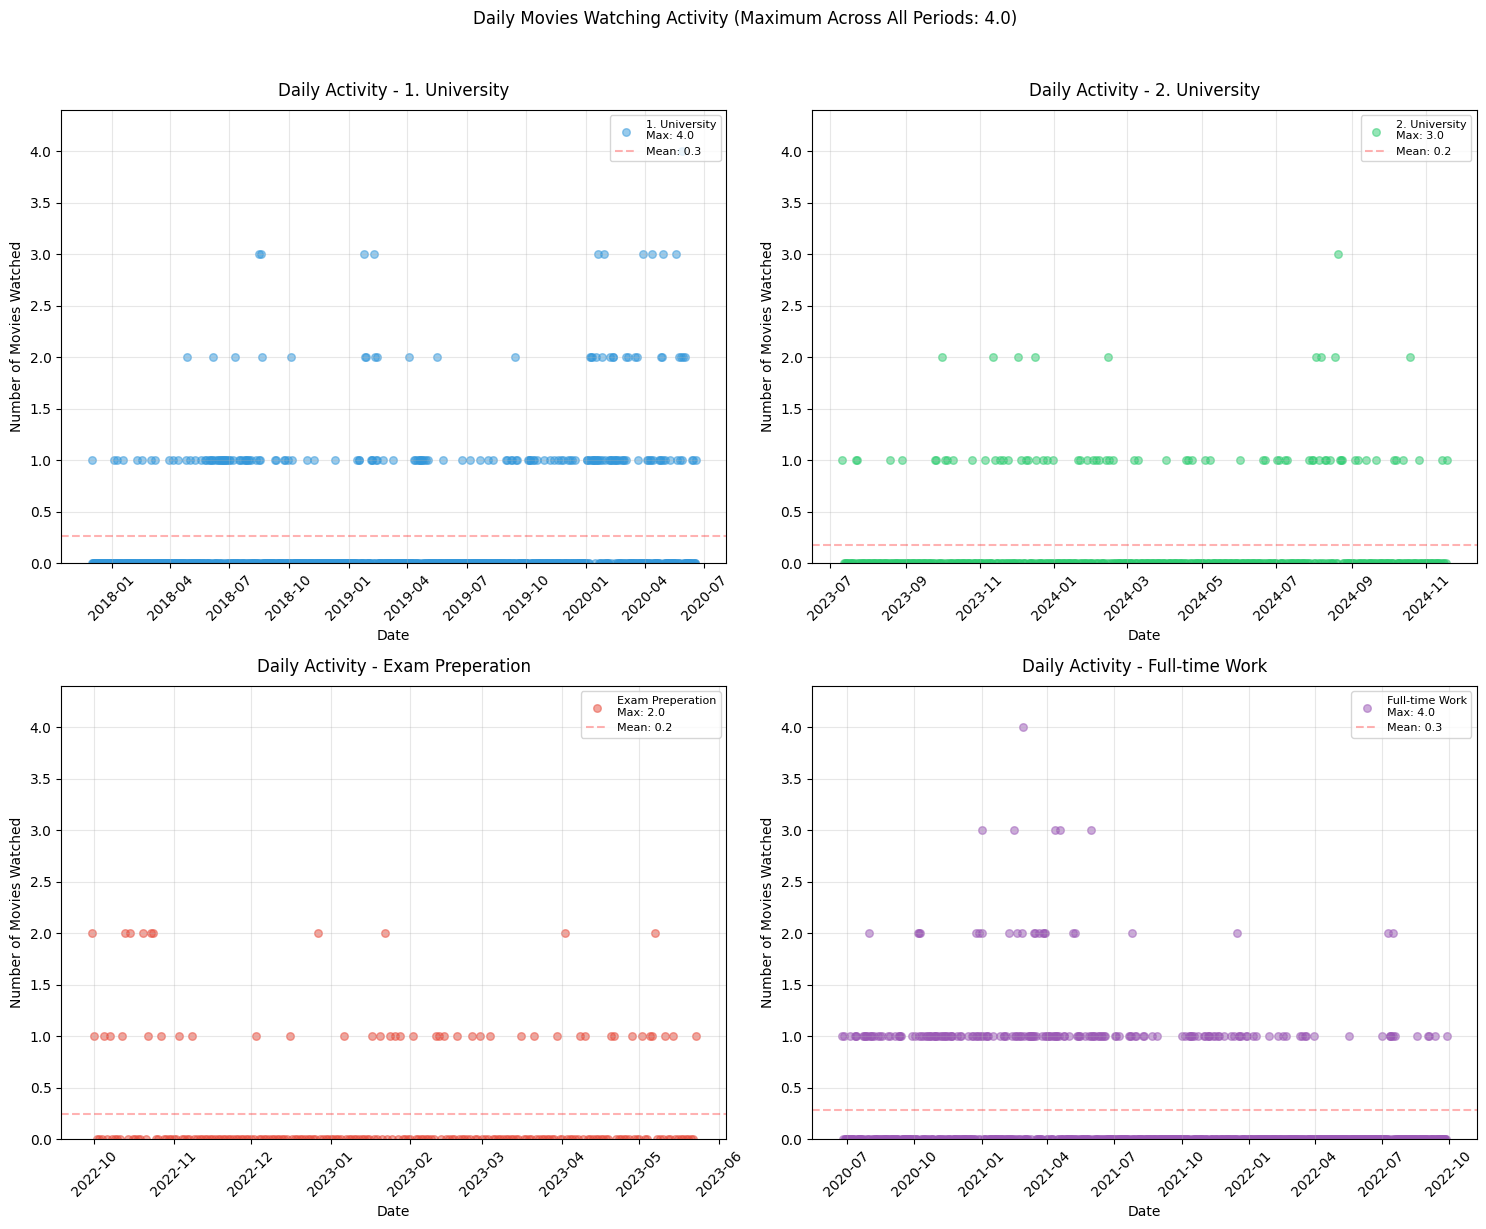


Summary Statistics by Period:
                 count                                      date              \
                  mean median  min  max    sum   std         min         max   
custom_period                                                                  
1. University     0.26    0.0  0.0  4.0  245.0  0.58  2017-12-01  2020-06-18   
2. University     0.18    0.0  0.0  3.0   88.0  0.44  2023-07-11  2024-11-18   
Exam Preperation  0.25    0.0  0.0  2.0   58.0  0.52  2022-09-30  2023-05-23   
Full-time Work    0.29    0.0  0.0  4.0  237.0  0.56  2020-06-25  2022-09-28   

                        
                 count  
custom_period           
1. University      931  
2. University      497  
Exam Preperation   236  
Full-time Work     826  


In [30]:
def create_activity_plots_standardized(complete_counts, title_prefix="Movies"):
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    max_count = complete_counts['count'].max()
    y_max = max_count * 1.1

    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

    for idx, (period, group) in enumerate(complete_counts.groupby('custom_period')):
        ax = axes[idx]

        ax.scatter(
            group['date'],
            group['count'],
            alpha=0.5,
            s=30,
            c=colors[idx],
            label=f'{period}\nMax: {group["count"].max()}'
        )

        ax.set_ylim(0, y_max)

        ax.set_title(f'Daily Activity - {period}', pad=10)
        ax.set_xlabel('Date')
        ax.set_ylabel(f'Number of {title_prefix} Watched')

        ax.tick_params(axis='x', rotation=45)

        ax.grid(True, alpha=0.3)

        mean_watches = group['count'].mean()
        ax.axhline(y=mean_watches, color='red', linestyle='--', alpha=0.3,
                  label=f'Mean: {mean_watches:.1f}')

        ax.legend(fontsize=8, loc='upper right')

    fig.suptitle(f'Daily {title_prefix} Watching Activity (Maximum Across All Periods: {max_count})',
                y=1.02, fontsize=12)

    plt.tight_layout()
    return fig

# Create visualizations
activity_fig = create_activity_plots_standardized(complete_counts_movies)
plt.show()

print("\nSummary Statistics by Period:")
print(summary_movies)

# Enhance Movie Data with Genre and Duration

To further understand my movie-watching patterns I wanted to analyze not just when I watched movies, but what kinds of movies I chose during different periods. To do this, I will:

1. Scrape additional movie details (genres and duration) from Letterboxd
2. Cache the results to avoid repeatedly hitting their website (to avoid being banned and increase the development speed)

This will help me understand if my movie preferences changed during different life periods. For example:
- Did I watch more comedies during stressful exam periods?
- Were my movie choices different during university vs. work life?
- Did my average movie duration change based on how busy I was?

In [31]:
# Cache management functions to avoid repeated web scraping
def load_cache(cache_file='movie_details_cache.json'):
    try:
        with open(cache_file, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

def save_cache(cache, cache_file='movie_details_cache.json'):
    with open(cache_file, 'w') as f:
        json.dump(cache, f)

# Function to resolve short URLs to full URLs
def resolve_short_url(short_url, headers):
    try:
        response = requests.get(short_url, headers=headers, allow_redirects=False)
        if response.status_code in (301, 302):
            full_url = response.headers['Location']
            if not full_url.startswith('http'):
                parsed = urlparse(short_url)
                full_url = f"{parsed.scheme}://{parsed.netloc}{full_url}"
            return full_url
        else:
            raise Exception(f"No redirect found for {short_url}")
    except Exception as e:
        print(f"Error resolving short URL {short_url}: {str(e)}")
        return None

# Obtained full URLs from short URLs are in this format:
# https://letterboxd.com/username/film/movie-name/1/
# But this page does not contain the movie details
# For that I have to go to the main oage of the film, which is in this format:
# https://letterboxd.com/film/movie-name/
def transform_url(url):
    url = re.sub(r'/\d+/?$', '/', url)
    main_url = re.sub(r'letterboxd\.com/[^/]+/film/', 'letterboxd.com/film/', url)
    main_url = main_url.rstrip('/') + '/'
    return main_url

# Function to scrape movie details from the main page
def get_movie_details(short_url, cache, headers):
    # Check if the movie details are already cached
    if short_url in cache:
        print(f"Found in cache: {short_url}")
        return cache[short_url]

    try:
        full_url = resolve_short_url(short_url, headers)
        if not full_url:
            raise Exception("Could not resolve short URL")

        main_url = transform_url(full_url)
        # Add random delay to be nice to Letterboxd's servers
        time.sleep(random.uniform(1, 3))

        print(f"Fetching: {main_url}")
        response = requests.get(main_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract genres
        genres = []
        genre_section = soup.find('div', {'class': 'text-sluglist capitalize'})
        if genre_section:
            genres = [a.text.strip() for a in genre_section.find_all('a')]

        # Extract duration
        duration = None
        details = soup.find('p', {'class': 'text-link text-footer'})
        if details:
            duration_text = details.text
            numbers = re.findall(r'\d+', duration_text)
            if numbers:
                duration = int(numbers[0])

        movie_info = {
            'genres': genres,
            'duration': duration,
        }
        cache[short_url] = movie_info
        return movie_info

    except Exception as e:
        print(f"Error processing {short_url}: {str(e)}")
        return {
            'genres': [],
            'duration': None
        }

# Main scraping function to process all movies
def scrape_movies(df):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    cache = load_cache()
    total_movies = len(df)

    for index, row in df.iterrows():
        short_url = row['Letterboxd URI']
        print(f"\nProcessing movie {index + 1}/{total_movies}")

        details = get_movie_details(short_url, cache, headers)

        df.at[index, 'genres'] = ','.join(details['genres']) if details['genres'] else ''
        df.at[index, 'duration'] = details['duration']

        if (index + 1) % 10 == 0:
            save_cache(cache)
            df.to_csv('movies_with_details.csv', index=False)
            print(f"Progress saved after {index + 1} movies")

    save_cache(cache)
    df.to_csv('movies_with_details.csv', index=False)
    print("Scraping completed!")

    return df

df_movies_genre_and_duration = scrape_movies(df_movies)


Processing movie 1/628
Found in cache: https://boxd.it/uSUfp

Processing movie 2/628
Found in cache: https://boxd.it/uSUqd

Processing movie 3/628
Found in cache: https://boxd.it/uSRrx

Processing movie 4/628
Found in cache: https://boxd.it/uSRBH

Processing movie 5/628
Found in cache: https://boxd.it/uSSm9

Processing movie 6/628
Found in cache: https://boxd.it/uSTPL

Processing movie 7/628
Found in cache: https://boxd.it/uSUln

Processing movie 8/628
Found in cache: https://boxd.it/uSUVb

Processing movie 9/628
Found in cache: https://boxd.it/uSUbH

Processing movie 10/628
Found in cache: https://boxd.it/uSSB9
Progress saved after 10 movies

Processing movie 11/628
Found in cache: https://boxd.it/uSTtb

Processing movie 12/628
Found in cache: https://boxd.it/uSUDr

Processing movie 13/628
Found in cache: https://boxd.it/uSRu7

Processing movie 14/628
Found in cache: https://boxd.it/uSSv1

Processing movie 15/628
Found in cache: https://boxd.it/uSUPd

Processing movie 16/628
Found in

# Analyze Movie Watching Patterns

1. Time Investment Analysis:
   - Calculate how many minutes per day I spent watching movies in each period
   - Understand if my movie time commitment changed during busy periods

2. Genre Preferences:
   - See if my genre choices shifted during different life phases
   - Check if I gravitated towards certain genres during stressful periods
   - Identify any seasonal patterns in my movie preferences

3. Viewing Patterns:
   - Look for changes in movie duration preferences
   - Analyze daily and monthly viewing habits
   - Identify any binge-watching patterns (if there is any)


Minutes Analysis by Period:
                 duration                         Watched Date             \
                    count      sum    mean median          min        max   
custom_period                                                               
1. University         244  27865.0  114.20  114.0   2017-12-01 2020-06-18   
2. University          88  11280.0  128.18  116.0   2023-07-11 2024-11-18   
Exam Preperation       58   7146.0  123.21  113.5   2022-09-30 2023-05-23   
Full-time Work        237  31284.0  132.00  112.0   2020-06-25 2022-09-28   

                  duration  
                 daily_avg  
custom_period               
1. University        29.96  
2. University        22.74  
Exam Preperation     30.41  
Full-time Work       37.92  

Detailed Statistics by Period:
Period | Total Minutes | Total Days | Minutes per Day
------------------------------------------------------------
1. University | 27,865 | 931 | 29.9
2. University | 11,280 | 497 | 22.7
Exam Prep

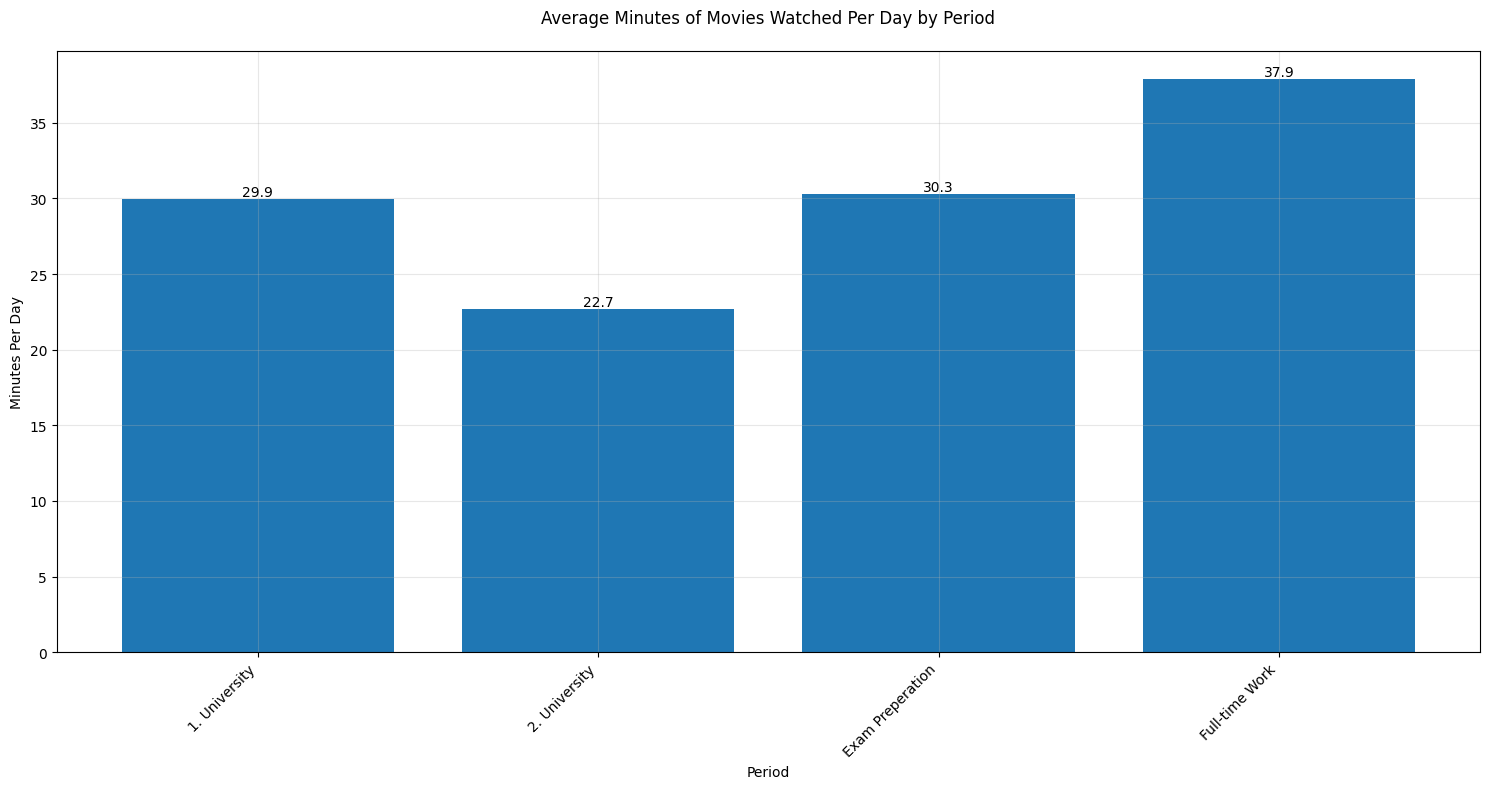

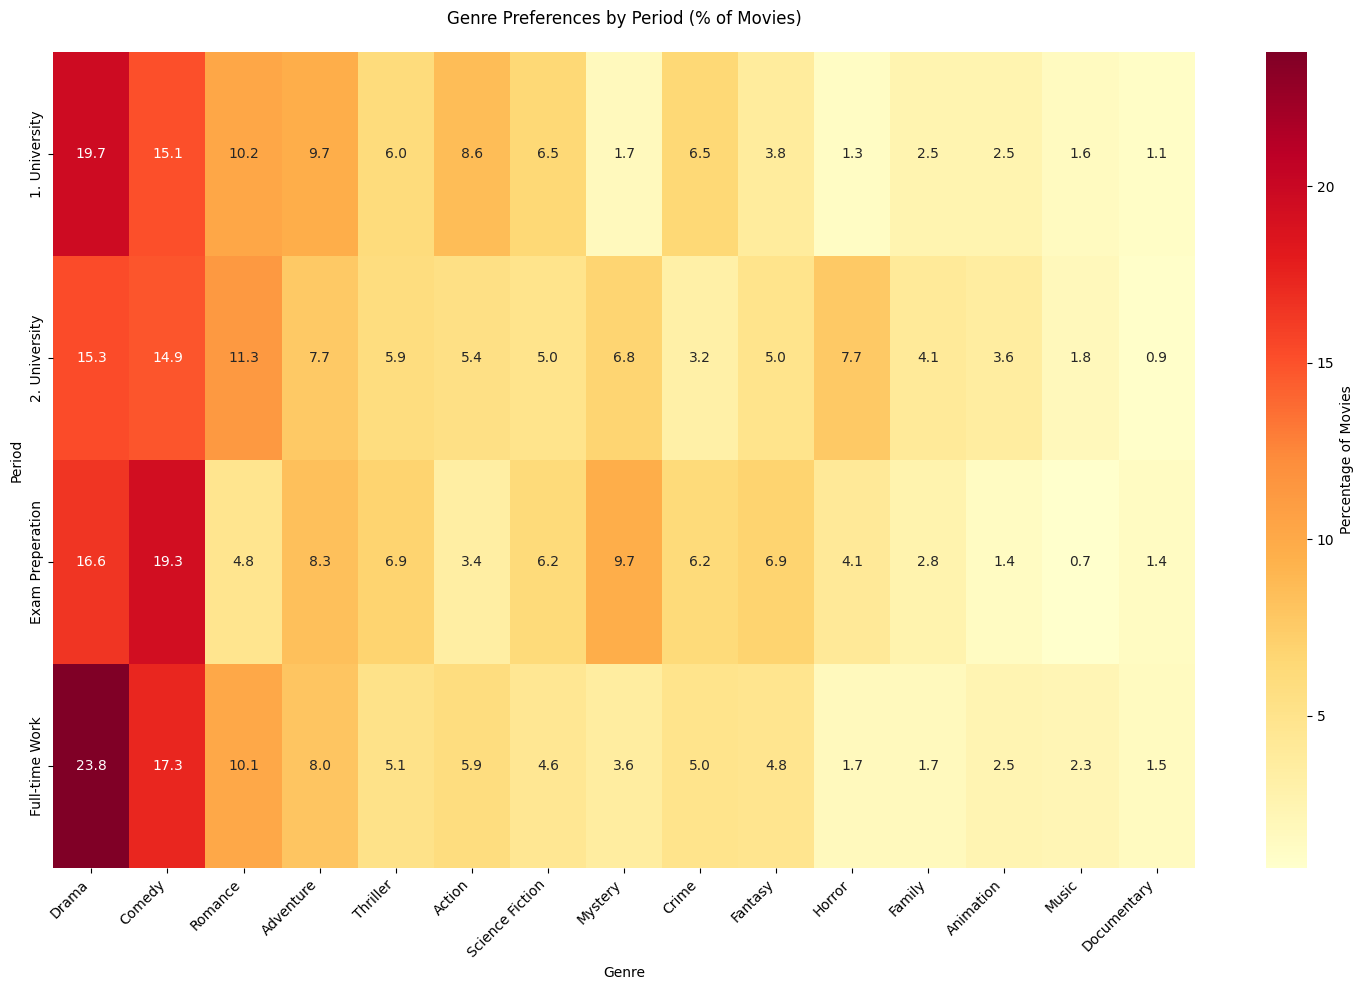

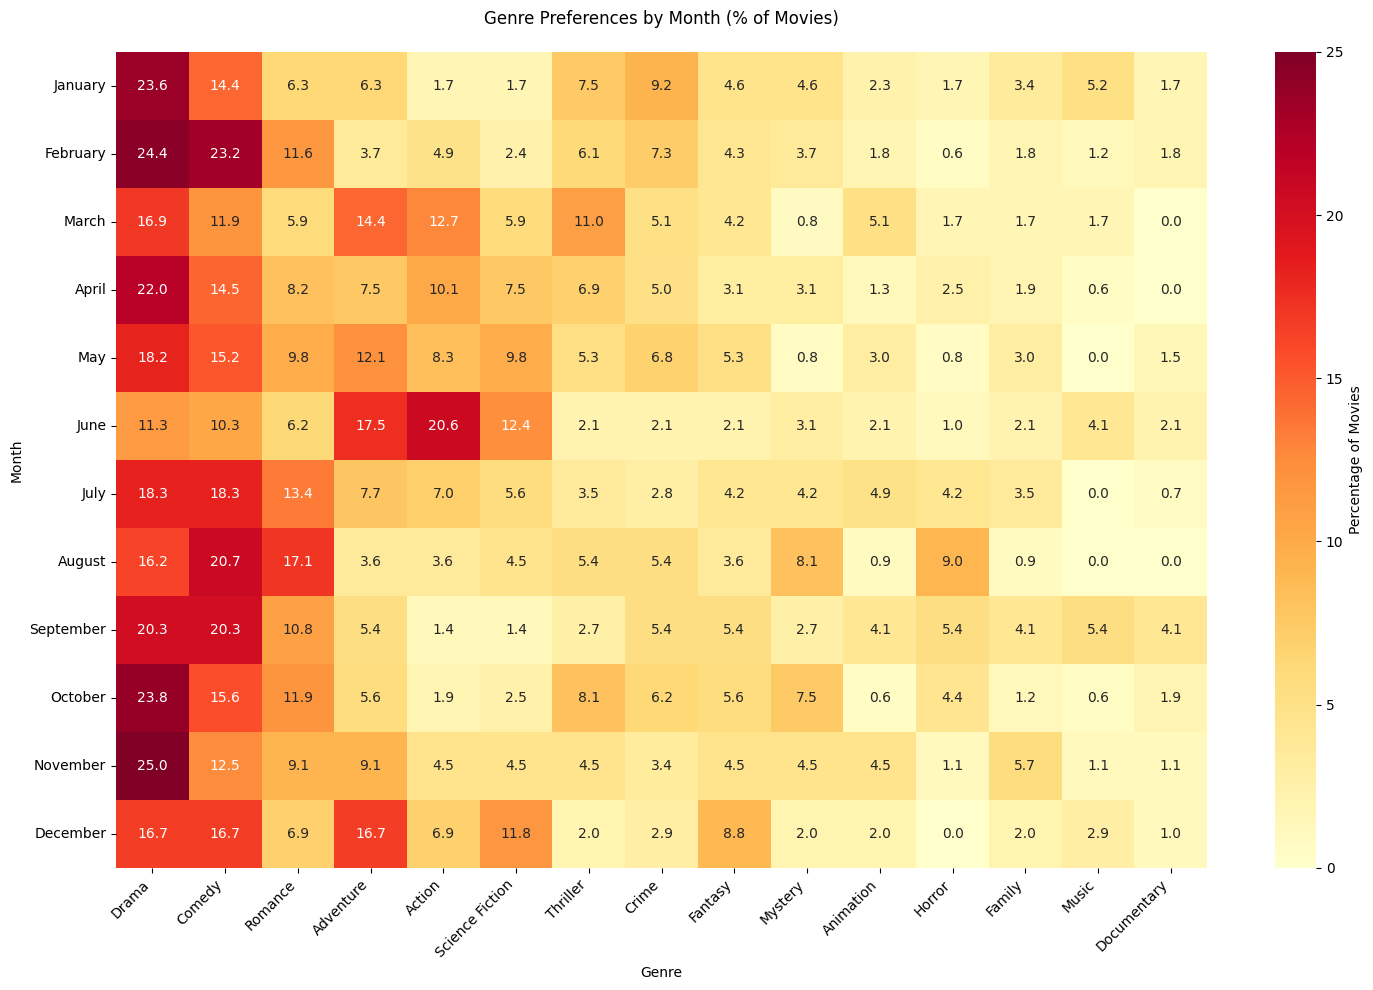

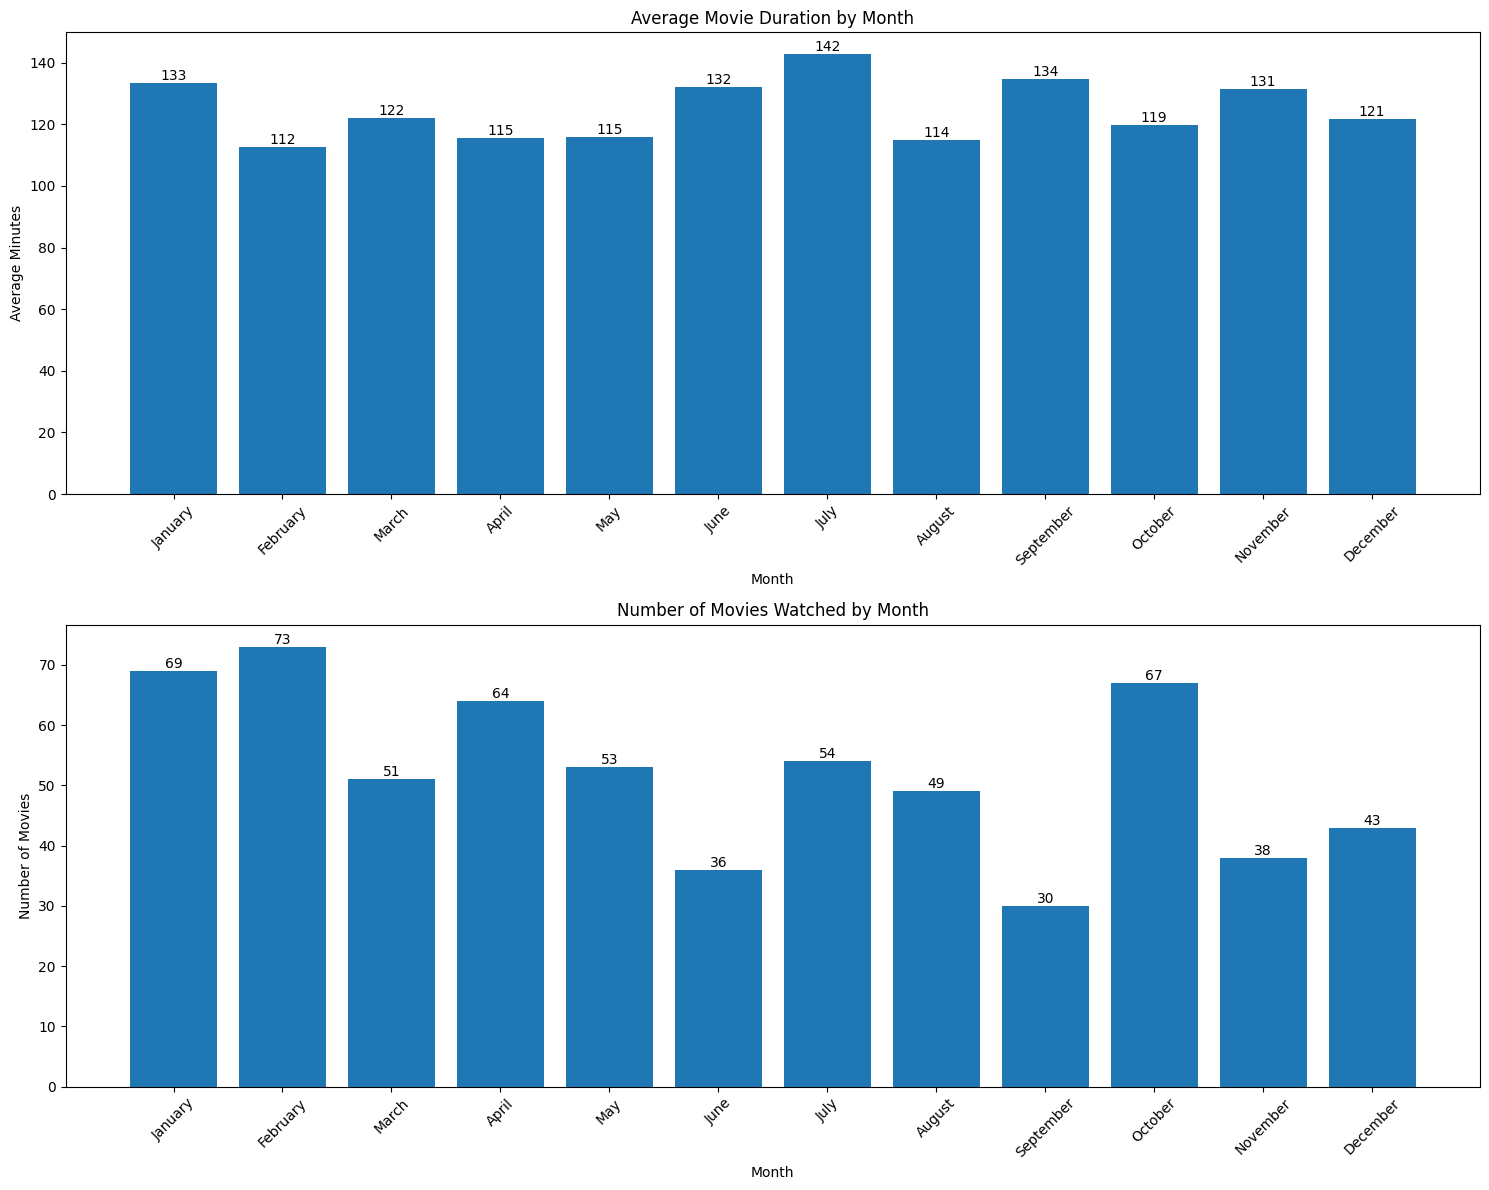

In [32]:
def analyze_minutes_by_period(df):
    minutes_by_period = df.groupby('custom_period').agg({
        'duration': ['count', 'sum', 'mean', 'median'],
        'Watched Date': ['min', 'max']
    }).round(2)

    minutes_by_period['duration', 'daily_avg'] = minutes_by_period.apply(
        lambda x: x[('duration', 'sum')] / (x[('Watched Date', 'max')] - x[('Watched Date', 'min')]).days,
        axis=1
    ).round(2)

    return minutes_by_period

def create_minutes_per_day_visualization(df):
    period_stats = df.groupby('custom_period').agg({
        'Watched Date': lambda x: (x.max() - x.min()).days + 1,
        'duration': 'sum'
    })

    # Calculate minutes per day
    period_stats['minutes_per_day'] = (period_stats['duration'] / period_stats['Watched Date']).round(2)

    plt.figure(figsize=(15, 8))
    bars = plt.bar(period_stats.index, period_stats['minutes_per_day'])
    plt.title('Average Minutes of Movies Watched Per Day by Period', pad=20)
    plt.xlabel('Period')
    plt.ylabel('Minutes Per Day')

    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    print("\nDetailed Statistics by Period:")
    print("Period | Total Minutes | Total Days | Minutes per Day")
    print("-" * 60)
    for period in period_stats.index:
        print(f"{period} | {period_stats.loc[period, 'duration']:,.0f} | {period_stats.loc[period, 'Watched Date']:,.0f} | {period_stats.loc[period, 'minutes_per_day']:.1f}")

    return plt.gcf()

def analyze_genres_by_period(df):
    genre_df = df.copy()
    genre_df['genre_list'] = genre_df['genres'].fillna('').str.split(',')
    genre_df = genre_df.explode('genre_list')
    genre_df['genre_list'] = genre_df['genre_list'].str.strip()

    genre_df = genre_df[genre_df['genre_list'].str.len() > 0]

    genre_counts = genre_df.groupby(['custom_period', 'genre_list']).size().unstack(fill_value=0)

    genre_percentages = genre_counts.div(genre_counts.sum(axis=1), axis=0) * 100

    return genre_percentages

def create_genre_heatmap(genre_percentages):
    plt.figure(figsize=(15, 10))

    top_genres = genre_percentages.sum().sort_values(ascending=False).head(15).index

    sns.heatmap(genre_percentages[top_genres],
               annot=True,
               fmt='.1f',
               cmap='YlOrRd',
               cbar_kws={'label': 'Percentage of Movies'})

    plt.title('Genre Preferences by Period (% of Movies)', pad=20)
    plt.ylabel('Period')
    plt.xlabel('Genre')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt.gcf()

def analyze_genres_by_month(df):
    genre_df = df.copy()
    genre_df['genre_list'] = genre_df['genres'].fillna('').str.split(',')
    genre_df = genre_df.explode('genre_list')
    genre_df['genre_list'] = genre_df['genre_list'].str.strip()
    genre_df['MonthName'] = genre_df['Watched Date'].dt.strftime('%B')

    genre_df = genre_df[genre_df['genre_list'].str.len() > 0]

    genre_counts = genre_df.groupby(['MonthName', 'genre_list']).size().unstack(fill_value=0)

    month_order = list(calendar.month_name)[1:]
    genre_counts = genre_counts.reindex(month_order)

    genre_percentages = genre_counts.div(genre_counts.sum(axis=1), axis=0) * 100

    return genre_percentages

def create_monthly_genre_heatmap(genre_percentages):
    plt.figure(figsize=(15, 10))

    top_genres = genre_percentages.sum().sort_values(ascending=False).head(15).index

    sns.heatmap(genre_percentages[top_genres],
               annot=True,
               fmt='.1f',
               cmap='YlOrRd',
               cbar_kws={'label': 'Percentage of Movies'})

    plt.title('Genre Preferences by Month (% of Movies)', pad=20)
    plt.ylabel('Month')
    plt.xlabel('Genre')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt.gcf()

def create_monthly_minutes_plot(df):
    df['MonthName'] = df['Watched Date'].dt.strftime('%B')
    monthly_avg = df.groupby('MonthName')['duration'].agg(['mean', 'count']).round(2)

    month_order = list(calendar.month_name)[1:]
    monthly_avg = monthly_avg.reindex(month_order)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    bars1 = ax1.bar(monthly_avg.index, monthly_avg['mean'])
    ax1.set_title('Average Movie Duration by Month')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Minutes')
    ax1.tick_params(axis='x', rotation=45)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    bars2 = ax2.bar(monthly_avg.index, monthly_avg['count'])
    ax2.set_title('Number of Movies Watched by Month')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Number of Movies')
    ax2.tick_params(axis='x', rotation=45)

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    plt.tight_layout()
    return fig

def analyze_movies(df):
    # Analyze minutes by period
    minutes_analysis = analyze_minutes_by_period(df)
    print("\nMinutes Analysis by Period:")
    print(minutes_analysis)

    # Minutes visualization
    minutes_fig = create_minutes_per_day_visualization(df)
    plt.show()

    # Genre analysis by period
    genre_percentages = analyze_genres_by_period(df)
    genre_heatmap = create_genre_heatmap(genre_percentages)
    plt.show()

    # Monthly analysis
    monthly_genre_percentages = analyze_genres_by_month(df)
    monthly_genre_heatmap = create_monthly_genre_heatmap(monthly_genre_percentages)
    plt.show()

    # Monthly minutes analysis
    monthly_minutes_fig = create_monthly_minutes_plot(df)
    plt.show()

analyze_movies(df_movies_genre_and_duration)

# Statistical Analysis of Entertainment Habits

1. Short-form Content (Instagram):
   - Did I engage more with Instagram during busy periods as a quick stress relief?
   - Was my Instagram usage more sporadic during exam preparation?

2. Long-form Content (Movies):
   - Did I watch fewer movies during busy periods?
   - Did I choose shorter movies when I was busier?

To answer these questions, I'll:
1. Define what constitutes "busy" periods (exam preparation)
2. Compare activity patterns between busy and less busy times
3. Use statistical tests to verify if any differences are significant
4. Visualize the differences to better understand the patterns

In [33]:
busy_periods = ['Exam Preperation']
less_busy_periods = ['1. University', '2. University', 'Full-time Work']

def calculate_daily_movie_duration(df):
    daily_duration = df.groupby(['Watched Date', 'custom_period'])['duration'].sum().reset_index()

    all_data = []

    for period in df['custom_period'].unique():
        period_data = daily_duration[daily_duration['custom_period'] == period]
        if not period_data.empty:
            date_range = pd.date_range(
                period_data['Watched Date'].min(),
                period_data['Watched Date'].max(),
                freq='D'
            )

            complete_period = pd.DataFrame({
                'Watched Date': date_range,
                'custom_period': period
            })

            complete_period = complete_period.merge(
                period_data,
                on=['Watched Date', 'custom_period'],
                how='left'
            )

            complete_period['duration'] = complete_period['duration'].fillna(0)
            all_data.append(complete_period)

    return pd.concat(all_data)

# Perform statistical tests
def statistical_analysis(instagram_df, movies_daily_duration):

    # Instagram analysis
    busy_instagram = instagram_df[instagram_df['custom_period'].isin(busy_periods)]['count']
    less_busy_instagram = instagram_df[instagram_df['custom_period'].isin(less_busy_periods)]['count']

    # Movie duration analysis
    busy_movies = movies_daily_duration[movies_daily_duration['custom_period'].isin(busy_periods)]['duration']
    less_busy_movies = movies_daily_duration[movies_daily_duration['custom_period'].isin(less_busy_periods)]['duration']

    # Mann-Whitney U tests
    instagram_stat = stats.mannwhitneyu(busy_instagram, less_busy_instagram, alternative='greater')
    movies_stat = stats.mannwhitneyu(less_busy_movies, busy_movies, alternative='greater')

    return {
        'instagram_test': instagram_stat,
        'movies_test': movies_stat,
        'instagram_means': (busy_instagram.mean(), less_busy_instagram.mean()),
        'movies_means': (busy_movies.mean(), less_busy_movies.mean())
    }

# Calculate effect size
def calculate_effect_size(busy_data, less_busy_data):
    n1, n2 = len(busy_data), len(less_busy_data)
    statistic, _ = stats.mannwhitneyu(busy_data, less_busy_data)
    effect_size = 1 - (2 * statistic) / (n1 * n2)
    return effect_size

# Process movie data
daily_movie_duration = calculate_daily_movie_duration(df_movies)

# Run analysis
stats_results = statistical_analysis(cleaned_counts_instagram, daily_movie_duration)

print("\nHypothesis Test Results:")
print("\n1. Instagram Activity (shorter content):")
print(f"Busy periods (Exam Prep) mean: {stats_results['instagram_means'][0]:.2f} posts/day")
print(f"Less busy periods (Work & University) mean: {stats_results['instagram_means'][1]:.2f} posts/day")
print(f"Mann-Whitney U test p-value: {stats_results['instagram_test'].pvalue:.4f}")

print("\n2. Movie Watching (minutes per day):")
print(f"Busy periods (Exam Prep) mean: {stats_results['movies_means'][0]:.2f} minutes/day")
print(f"Less busy periods (Work & University) mean: {stats_results['movies_means'][1]:.2f} minutes/day")
print(f"Mann-Whitney U test p-value: {stats_results['movies_test'].pvalue:.4f}")


Hypothesis Test Results:

1. Instagram Activity (shorter content):
Busy periods (Exam Prep) mean: 12.28 posts/day
Less busy periods (Work & University) mean: 17.41 posts/day
Mann-Whitney U test p-value: 1.0000

2. Movie Watching (minutes per day):
Busy periods (Exam Prep) mean: 30.28 minutes/day
Less busy periods (Work & University) mean: 31.25 minutes/day
Mann-Whitney U test p-value: 0.4395


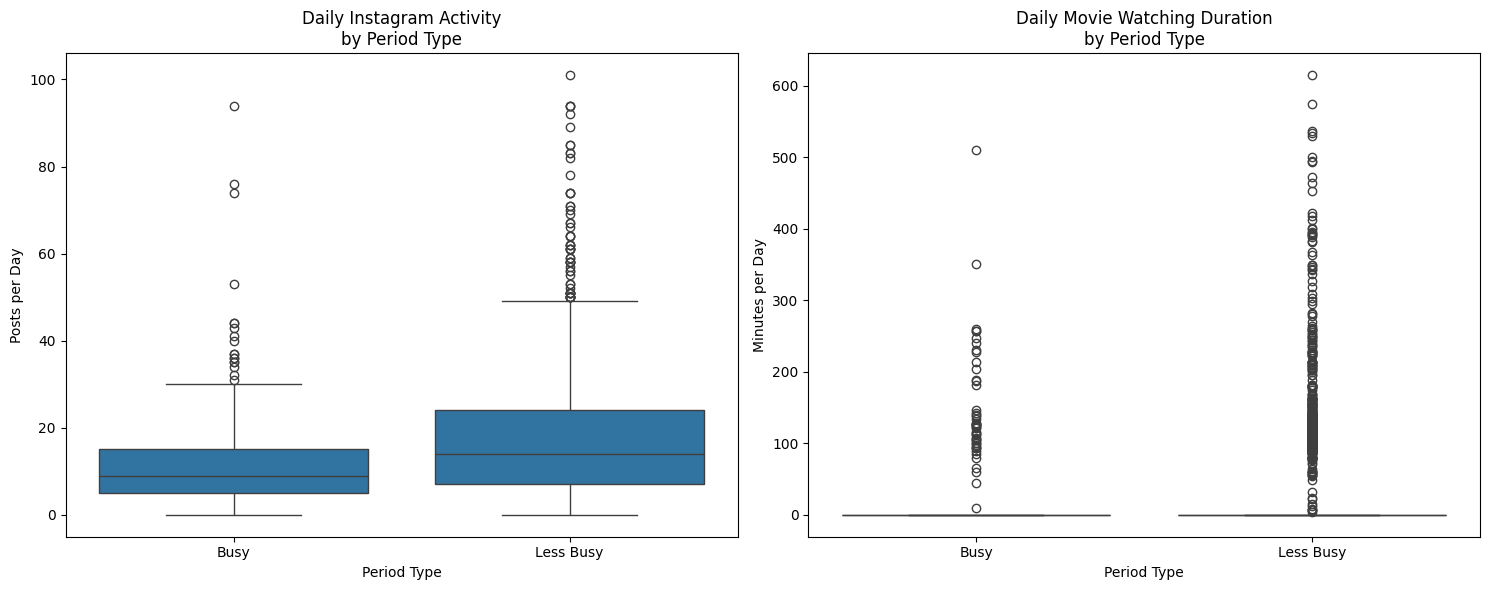


Effect Sizes (positive indicates higher values in busy periods):
Instagram effect size: 0.224
Movies effect size: 0.004


In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Instagram comparison
busy_insta = cleaned_counts_instagram[cleaned_counts_instagram['custom_period'].isin(busy_periods)]
less_busy_insta = cleaned_counts_instagram[cleaned_counts_instagram['custom_period'].isin(less_busy_periods)]

data_insta = pd.DataFrame({
    'Activity': busy_insta['count'].tolist() + less_busy_insta['count'].tolist(),
    'Period Type': ['Busy'] * len(busy_insta) + ['Less Busy'] * len(less_busy_insta)
})

sns.boxplot(data=data_insta, x='Period Type', y='Activity', ax=ax1)
ax1.set_title('Daily Instagram Activity\nby Period Type')
ax1.set_ylabel('Posts per Day')

# Movie duration comparison
busy_movies = daily_movie_duration[daily_movie_duration['custom_period'].isin(busy_periods)]
less_busy_movies = daily_movie_duration[daily_movie_duration['custom_period'].isin(less_busy_periods)]

data_movies = pd.DataFrame({
    'Duration': busy_movies['duration'].tolist() + less_busy_movies['duration'].tolist(),
    'Period Type': ['Busy'] * len(busy_movies) + ['Less Busy'] * len(less_busy_movies)
})

sns.boxplot(data=data_movies, x='Period Type', y='Duration', ax=ax2)
ax2.set_title('Daily Movie Watching Duration\nby Period Type')
ax2.set_ylabel('Minutes per Day')

plt.tight_layout()
plt.show()

# Calculate and print effect sizes
print("\nEffect Sizes (positive indicates higher values in busy periods):")
busy_instagram = cleaned_counts_instagram[cleaned_counts_instagram['custom_period'].isin(busy_periods)]['count']
less_busy_instagram = cleaned_counts_instagram[cleaned_counts_instagram['custom_period'].isin(less_busy_periods)]['count']
busy_movies = daily_movie_duration[daily_movie_duration['custom_period'].isin(busy_periods)]['duration']
less_busy_movies = daily_movie_duration[daily_movie_duration['custom_period'].isin(less_busy_periods)]['duration']

print(f"Instagram effect size: {calculate_effect_size(busy_instagram, less_busy_instagram):.3f}")
print(f"Movies effect size: {calculate_effect_size(busy_movies, less_busy_movies):.3f}")

The statistical tests reveal patterns in how my entertainment consumption changed during busy vs. less busy periods:

## Instagram Activity
- During busy periods (Exam Prep), I averaged 12.28 posts/day
- During less busy periods (Work & University), I averaged 17.41 posts/day
- The Mann-Whitney U test p-value of 1.0000 suggests this difference is not statistically significant
- However, there is a moderate effect size of 0.224, indicating that while not statistically significant, there might be a practical difference in Instagram usage between periods

## Movie Watching
- During busy periods, I watched an average of 30.28 minutes of movies per day
- During less busy periods, this slightly increased to 31.25 minutes per day
- The Mann-Whitney U test p-value of 0.4395 indicates this difference is not statistically significant
- The tiny effect size of 0.004 confirms that my movie watching habits were virtually identical between periods

## Key Insights
1. While statistical tests show no significant differences, the effect sizes tell a more detailed story
2. Instagram usage shows a moderate practical difference between periods (effect size 0.224), suggesting some change in behavior even if not statistically significant
3. Movie watching remained remarkably consistent (effect size 0.004), indicating I maintained similar viewing habits regardless of how busy I was
4. The contrast between Instagram's moderate effect size and movies' negligible effect size suggests that short-form content consumption was more affected by life circumstances than long-form content
5. This might indicate that while I preserved my movie-watching routine, my Instagram habits were more susceptible to change based on life circumstances

These findings provide a more detailed view of my entertainment consumption patterns, showing that while movie watching remained stable, Instagram usage showed practical (though not statistically significant) variations across different life periods.

# Analyzing Individual Movie Length Choices

After looking at overall patterns, I will look into my specific movie choices. Instead of just looking at total minutes per day, I want to understand:

1. Did I choose shorter movies during busy periods?
   - This might indicate strategic choices in entertainment consumption
   - For example, picking a 90-minute movie instead of a 3-hour epic during exam prep

2. How consistent were my movie length preferences?
   - Did my preference for movie duration vary by period?
   - Were there any notable outliers (very long or short movies)?

3. What was the typical movie length in each period?
   - Looking at means, medians, and standard deviations
   - Understanding if my movie length choices were more variable in certain periods

In [35]:
def analyze_movie_lengths(df):
    df_clean = df.dropna(subset=['duration', 'custom_period'])

    movie_lengths = df_clean.groupby('custom_period')['duration'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2)

    busy_lengths = df_clean[df_clean['custom_period'].isin(busy_periods)]['duration']
    less_busy_lengths = df_clean[df_clean['custom_period'].isin(less_busy_periods)]['duration']

    if len(busy_lengths) > 0 and len(less_busy_lengths) > 0:
        length_test = stats.mannwhitneyu(less_busy_lengths, busy_lengths, alternative='greater')
        effect_size = (len(busy_lengths) * len(less_busy_lengths) - 2 * length_test.statistic) / (len(busy_lengths) * len(less_busy_lengths))
    else:
        length_test = None
        effect_size = None

    return movie_lengths, length_test, effect_size

# Run analysis
movie_length_stats, length_test, effect_size = analyze_movie_lengths(df_movies)

print("\nMovie Length Analysis:")
print("\nAverage Movie Length by Period:")
print(movie_length_stats)

if length_test:
    print(f"\nMann-Whitney U test p-value: {length_test.pvalue:.4f}")
    print(f"\nEffect size for movie length difference: {effect_size:.3f}")
else:
    print("\nInsufficient data for statistical testing")


Movie Length Analysis:

Average Movie Length by Period:
                    mean  median    std  count
custom_period                                 
1. University     114.20   114.0  32.26    244
2. University     128.18   116.0  66.37     88
Exam Preperation  123.21   113.5  69.83     58
Full-time Work    132.00   112.0  91.28    237

Mann-Whitney U test p-value: 0.3040

Effect size for movie length difference: -0.041


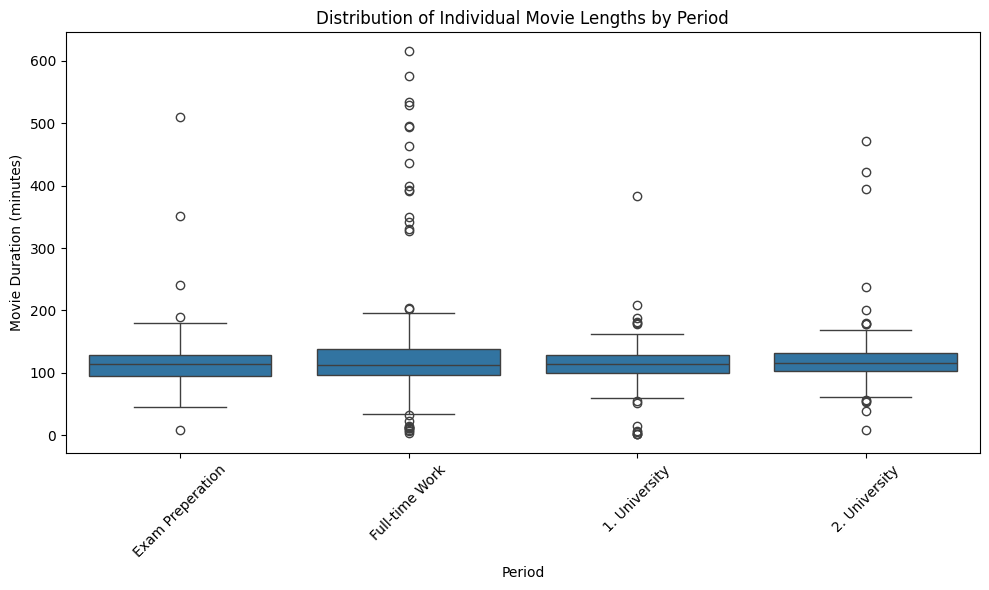


Summary by Period Type:

Busy Periods (Exam Prep):
mean      123.21
median    113.50
std        69.83
Name: duration, dtype: float64

Less Busy Periods (University):
mean      123.78
median    114.00
std        68.21
Name: duration, dtype: float64


In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_movies.dropna(subset=['duration']),
            x='custom_period',
            y='duration',
            order=['Exam Preperation', 'Full-time Work', '1. University', '2. University'])
plt.title('Distribution of Individual Movie Lengths by Period')
plt.xlabel('Period')
plt.ylabel('Movie Duration (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add summary statistics by period type
print("\nSummary by Period Type:")
print("\nBusy Periods (Exam Prep):")
busy_stats = df_movies[df_movies['custom_period'].isin(busy_periods)]['duration'].agg(['mean', 'median', 'std']).round(2)
print(busy_stats)

print("\nLess Busy Periods (University):")
less_busy_stats = df_movies[df_movies['custom_period'].isin(less_busy_periods)]['duration'].agg(['mean', 'median', 'std']).round(2)
print(less_busy_stats)

# Analysis of Movie Length Choices

## Period-by-Period Analysis
- **1. University**: Average movie length of 114.20 minutes with relatively consistent choices (std dev: 32.26)
- **2. University**: Slightly longer average of 128.18 minutes but more variable choices (std dev: 66.37)
- **Exam Preparation**: Mean length of 123.21 minutes with high variability (std dev: 69.83)
- **Full-time Work**: Longest average at 132.00 minutes with the most variability (std dev: 91.28)

## Busy vs. Less Busy Periods
- **Busy Periods**: Average movie length of 123.21 minutes (median: 113.50)
- **Less Busy Periods**: Very similar average of 123.78 minutes (median: 114.00)
- The Mann-Whitney U test p-value of 0.3040 indicates no significant difference
- The small negative effect size (-0.041) confirms that movie length choices were nearly identical between periods

## Key Insights
1. Despite different life circumstances, I maintained remarkably consistent movie length preferences
2. The median movie length stayed around 112-116 minutes across all periods, suggesting a "sweet spot" for my attention span
3. Interestingly, variability in choices increased over time (from std dev of 32.26 in early university to 91.28 during work)
4. Full-time work period showed the most diverse choices, perhaps reflecting more flexibility in entertainment scheduling
5. The similarity between busy and less busy periods suggests that when I chose to watch a movie, the time commitment wasn't a major factor in my selection

This analysis suggests that while my overall movie watching frequency might have changed, when I did choose to watch a movie, I didn't significantly alter my preferences for movie length based on how busy I was.

# Analyzing Entertainment Habits During High vs. Low Stress Periods

After examining busy vs. less busy periods, I wanted to look at my entertainment consumption through my stress levels. I categorized my periods as:

**High Stress**
- Exam Preparation
- 1. University
- 2. University

**Low Stress**
- Full-time Work

The goal was to understand:
1. Did stress levels affect my entertainment choices differently than just being "busy"?
2. Was there a difference in how I consumed short vs. long-form content during stressful periods?
3. Did the predictability of work life (low stress) vs. university/exam life (high stress) impact my entertainment habits?


Instagram Usage Analysis by Stress Level:

High Stress (University & Exam) average posts/day: 14.21 ± 13.03
Low Stress (Work) average posts/day: 21.28 ± 16.61

Mann-Whitney U test p-value: 1.0000
Effect size: 0.286


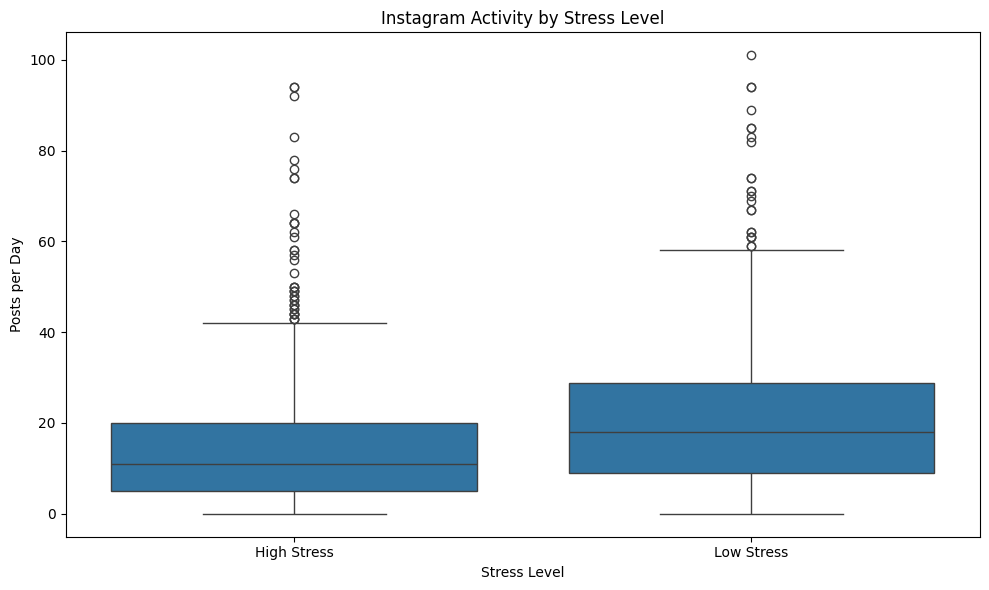

In [37]:
high_stress_periods = ['Exam Preperation', '1. University', '2. University']
low_stress_periods = ['Full-time Work']

def analyze_stress_periods(df):
    high_stress_data = df[df['custom_period'].isin(high_stress_periods)]['count']
    low_stress_data = df[df['custom_period'].isin(low_stress_periods)]['count']

    test_results = stats.mannwhitneyu(high_stress_data, low_stress_data, alternative='greater')

    n1, n2 = len(high_stress_data), len(low_stress_data)
    effect_size = (n1 * n2 - 2 * test_results.statistic) / (n1 * n2)

    return {
        'high_stress_mean': high_stress_data.mean(),
        'low_stress_mean': low_stress_data.mean(),
        'high_stress_std': high_stress_data.std(),
        'low_stress_std': low_stress_data.std(),
        'test_stat': test_results.statistic,
        'p_value': test_results.pvalue,
        'effect_size': effect_size
    }

results = analyze_stress_periods(cleaned_counts_instagram)

print("\nInstagram Usage Analysis by Stress Level:")
print(f"\nHigh Stress (University & Exam) average posts/day: {results['high_stress_mean']:.2f} ± {results['high_stress_std']:.2f}")
print(f"Low Stress (Work) average posts/day: {results['low_stress_mean']:.2f} ± {results['low_stress_std']:.2f}")
print(f"\nMann-Whitney U test p-value: {results['p_value']:.4f}")
print(f"Effect size: {results['effect_size']:.3f}")

# Visualize
plt.figure(figsize=(10, 6))
data = pd.DataFrame({
    'Activity': cleaned_counts_instagram['count'],
    'Stress Level': cleaned_counts_instagram['custom_period'].map({
        'Exam Preperation': 'High Stress',
        '1. University': 'High Stress',
        '2. University': 'High Stress',
        'Full-time Work': 'Low Stress'
    })
})

sns.boxplot(data=data, x='Stress Level', y='Activity',
            order=['High Stress', 'Low Stress'])
plt.title('Instagram Activity by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Posts per Day')
plt.tight_layout()
plt.show()

## Instagram Usage Analysis by Stress Level:
- High Stress (University & Exam) average posts/day: 14.21 ± 13.03
- Low Stress (Work) average posts/day: 21.28 ± 16.61
- Mann-Whitney U test p-value: 1.0000 indicates no statistically significant difference
- Effect size: 0.286 suggests a moderate practical difference

## Key Findings
1. While not statistically significant (p = 1.0000), there was actually higher Instagram usage during low-stress work periods
2. The moderate effect size (0.286) indicates a practically meaningful difference in usage patterns
3. The higher standard deviation during work periods (16.61 vs 13.03) suggests more variable usage patterns during low-stress times
4. This contradicts our initial hypothesis that stress might lead to increased social media use
5. The data suggests I might have had more consistent routines during high-stress periods, while allowing for more varied usage during more relaxed work life

This analysis reveals that my Instagram usage patterns were different than expected, with higher and more variable usage during low-stress work periods rather than during high-stress academic times. This might indicate that during high-stress periods, I maintained more structured and controlled social media habits.